# Import

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline
from nltk import sent_tokenize
from glob import glob
import warnings
warnings.filterwarnings('ignore')


/Users/ngkuissi/miniforge3/envs/series_analysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the model

In [3]:
model_name = "facebook/bart-large-mnli"
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

In [4]:
def load_model(device="cpu", model_name=model_name):
    theme_classifier = pipeline(
        task="zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier

In [5]:
theme_classifier = load_model(device=device)

In [6]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue", "pain", "hatred", "dream", "hard work", "war"]

In [8]:
classification = theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)
classification

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'hard work',
  'self development',
  'pain',
  'war',
  'hope',
  'hatred',
  'dream',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121251702308655,
  0.6919595003128052,
  0.4749987721443176,
  0.4389338493347168,
  0.35820794105529785,
  0.08781738579273224,
  0.0643683597445488,
  0.04519854485988617,
  0.04500005766749382,
  0.020132755860686302,
  0.012040241621434689,
  0.0042922901920974255,
  0.0028172011952847242]}

In [11]:
classification['scores']

[0.9121251702308655,
 0.6919595003128052,
 0.4749987721443176,
 0.4389338493347168,
 0.35820794105529785,
 0.08781738579273224,
 0.0643683597445488,
 0.04519854485988617,
 0.04500005766749382,
 0.020132755860686302,
 0.012040241621434689,
 0.0042922901920974255,
 0.0028172011952847242]

# Working with our dataset

In [12]:
files = glob("../data/subtitles/*.ass")
files[:5]

['../data/subtitles/Naruto Season 4 - 94.ass',
 '../data/subtitles/Naruto Season 4 - 80.ass',
 '../data/subtitles/Naruto Season 2 - 32.ass',
 '../data/subtitles/Naruto Season 8 - 185.ass',
 '../data/subtitles/Naruto Season 8 - 191.ass']

In [13]:
with open(files[0], "r") as file:
    lines = file.readlines()
    lines = lines[27:] # read only the lines after the metadata
    lines = [line.split(",")[9:] for line in lines] # remove all data with that is not part of the text column
    # some sentences may have , and we don't want a 2d list 
    lines = ["".join(line) for line in lines] # we will combine this in the main file

In [14]:
lines[:10]

['We are Fighting Dreamers aiming high\n',
 "Fighting Dreamers\\Ndon't care what people think about them\n",
 'Fighting Dreamers\\Nfollow what they believe\n',
 'Oli Oli Oli Oh! Just go my way\n',
 'Right here right now (Bang)\\NHit it straight like a line drive!\n',
 'Right here right now (Burn)\n',
 'Down a difficult road\\Nfilled with endless struggles\n',
 "Where do you think you are going\\Nfollowing someone else's map?\n",
 'An insightful crow comes along\\Nto tear up the map\n',
 'Now open your eyes and\\Ntake a look at the truth (Yeah!)\n']

*Note:* looks good however we have \\N character showing up

In [17]:
lines = [line.replace('\\N', '') for line in lines]

In [18]:
print(" ".join(lines[:10]))

We are Fighting Dreamers aiming high
 Fighting Dreamersdon't care what people think about them
 Fighting Dreamersfollow what they believe
 Oli Oli Oli Oh! Just go my way
 Right here right now (Bang)Hit it straight like a line drive!
 Right here right now (Burn)
 Down a difficult roadfilled with endless struggles
 Where do you think you are goingfollowing someone else's map?
 An insightful crow comes alongto tear up the map
 Now open your eyes andtake a look at the truth (Yeah!)



*Good*: now let us work with anotating the episode in question

In [19]:
files[2]

'../data/subtitles/Naruto Season 2 - 32.ass'

In [20]:
int(files[2].split('-')[-1].split('.')[0].strip())

32

In [22]:
def load_subtitles_dataset(dataset_path="../data/subtitles/"):
    subtitles_data = glob(dataset_path+"/*.ass")
    
    scripts = []
    #episode_nums = []
    
    for path in subtitles_data:
        
        # read file
        with open(path, "r") as file:
            lines = file.readlines()
            
        lines = lines[27:]
        lines = [line.split(",")[9:] for line in lines]
        lines = ["".join(line) for line in lines]
        lines = [line.replace('\\N', '') for line in lines]
        script = " ".join(lines)
        scripts.append(script)
        
        # getting the episode in question
        #episode_num = int(path.split('-')[-1].split('.')[0].strip())
        #episode_nums.append(episode_num)
    
    df = pd.DataFrame.from_dict({"script": scripts})
    return df

In [27]:
df = load_subtitles_dataset()

In [28]:
df.head(10)

,script
0,We are Fighting Dreamers aiming high\n Fightin...
1,We are Fighting Dreamers aiming high\n Fightin...
2,Press down hard on the gas\n That’s right ther...
3,Rock away your existence\n Shouting that you a...
4,Rock away your existence\n Shouting that you a...
5,Rock away your existence\n Shouting that you a...
6,Rock away your existence\n Shouting that you a...
7,Press down hard on the gas\n That’s right ther...
8,Press down hard on the gas\n That’s right ther...
9,We are Fighting Dreamers aiming high\n Fightin...


## Test the model

In [32]:
script = df.iloc[2]["script"]

In [50]:
script_sentences = sent_tokenize(script)
script_sentences[-1]


'!'

In [34]:
print(len(script_sentences))

225


In [51]:
# create batces of sentences
sentence_batch = 32
script_batches = []
for index in range(0, len(script_sentences), sentence_batch):
    sent = ""
    if index+sentence_batch <= len(script_sentences): 
        sent = " ".join(script_sentences[index:index+sentence_batch])
    else:
        sent = " ".join(script_sentences[index:]) # take last element in the batch
    script_batches.append(sent)


In [52]:
model_name = "facebook/bart-large-mnli"
def load_model(device="cpu", model_name=model_name):
    theme_classifier = pipeline(
        task="zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier

In [53]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue", "pain", "hatred", "dream", "hard work", "war"]

In [54]:
len(script_batches)

8

In [55]:
theme_classifier = load_model(device=device)
theme_output = theme_classifier(
    script_batches,
    theme_list,
    multi_label=True
)

In [58]:
theme_output[4]

{'sequence': 'With such a simple and basic Ninjutsu...\n you think you can come at me?! Kin get out of the way! Useless! Air pressure 100 percentultrasonic waves 0% output...\n Is that all you can do? Slicing Sound Wave! You’re easy to spot...\n You’re above! I’ve said it two or three times thatthat won’t work! This is enough... for you! Where next? Huh?! What...?! This time... it’s not a substitution! Get off me! Hey! Sakura...\n You’re always being called“Billboard Brow” and being picked on. Who’re you? I’m called Ino Yamanaka.How ‘bout you? I’m... Sakura. Huh? I can’t hear you.Say it louder. Sakura Haruno! Huh I see. You have a wide forehead. So Billboard Brow huh...? That’s why you hideyour forehead with your bangs. Like a ghost...\n Sakura was it? Uh-huh...\n Come back here tomorrow. I’ll give you something nice. Huh? Darn let go! See! You look cuter like this Sakura!',
 'labels': ['dialogue',
  'friendship',
  'self development',
  'battle',
  'hard work',
  'hope',
  'love',
  '

In [59]:
# get all the outputs together
# for Example
# battle: [0.4, 0.65]
themes_probs = {}
for output in theme_output:
    for label,score in zip(output['labels'], output["scores"]):
        themes_probs[label] = [score] + themes_probs.get(label, [])

In [60]:
themes_prob = {key: np.mean(np.array(value)) for key,value in themes_probs.items()}

In [61]:
themes_prob

{'hard work': 0.8587061613798141,
 'hope': 0.5133965294808149,
 'sacrifice': 0.7477323077619076,
 'battle': 0.8607199266552925,
 'dream': 0.5781897082924843,
 'self development': 0.7899001613259315,
 'love': 0.3773640119470656,
 'war': 0.580585302785039,
 'dialogue': 0.8418986573815346,
 'pain': 0.5758563932031393,
 'friendship': 0.5428784536197782,
 'hatred': 0.35366878379136324,
 'betrayal': 0.5415903478860855}

In [63]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
    
    # batch Sentences
    sentence_batch = 32
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch):
        sent = ""
        if index+sentence_batch <= len(script_sentences): 
            sent = " ".join(script_sentences[index:index+sentence_batch])
        else:
            sent = " ".join(script_sentences[index:])
        script_batches.append(sent)
    
    # Run model
    theme_output = theme_classifier( 
        script_batches[:2], # for the purposes of this notebook we only focus on the first 10 however, in the main file we will work without all the data
        theme_list,
        multi_label=True
    )
    # join output 
    themes_probs = {}
    for output in theme_output:
        for label,score in zip(output['labels'], output["scores"]):
            themes_probs[label] = [score] + themes_probs.get(label, [])
    
    themes_prob = {key: np.mean(np.array(value)) for key,value in themes_probs.items()}
    
    return themes_prob
    

In [64]:
df.head()

,script
0,We are Fighting Dreamers aiming high\n Fightin...
1,We are Fighting Dreamers aiming high\n Fightin...
2,Press down hard on the gas\n That’s right ther...
3,Rock away your existence\n Shouting that you a...
4,Rock away your existence\n Shouting that you a...


In [65]:
output_themes = df.head()['script'].apply(get_themes_inference)

In [66]:
output_themes

0    {'hard work': 0.9503165483474731, 'betrayal': ...
1    {'hard work': 0.9642726182937622, 'battle': 0....
2    {'hard work': 0.9463073313236237, 'hope': 0.63...
3    {'dialogue': 0.9177160263061523, 'hard work': ...
4    {'pain': 0.8051088154315948, 'self development...
Name: script, dtype: object

In [67]:
theme_df = pd.DataFrame(output_themes.tolist())

In [68]:
theme_df

,hard work,betrayal,battle,dialogue,war,sacrifice,self development,pain,dream,hatred,hope,friendship,love
0,0.950317,0.919255,0.961080,0.863835,0.882135,0.908269,0.751922,0.656352,0.340699,0.527435,0.183369,0.104728,0.049290
1,0.964273,0.628449,0.839320,0.867101,0.640021,0.671815,0.756013,0.866784,0.455585,0.493695,0.081513,0.093187,0.056692
2,0.946307,0.480935,0.910728,0.804208,0.683933,0.813866,0.753840,0.749233,0.816658,0.360889,0.635667,0.708908,0.449132
3,0.838509,0.331138,0.406944,0.917716,0.140688,0.580790,0.825880,0.663340,0.280936,0.084667,0.187405,0.581278,0.175452
4,0.928600,0.939418,0.862218,0.927940,0.660728,0.873519,0.886586,0.805109,0.431537,0.414088,0.397373,0.537138,0.343116


In [72]:
theme_df = theme_df.sum().reset_index()

In [73]:
theme_df.columns = ['theme','score']
theme_df

,theme,score
0,hard work,4.628005
1,betrayal,3.299194
2,battle,3.980289
3,dialogue,4.380801
4,war,3.007505
5,sacrifice,3.848258
6,self development,3.974241
7,pain,3.740817
8,dream,2.325415
9,hatred,1.880775


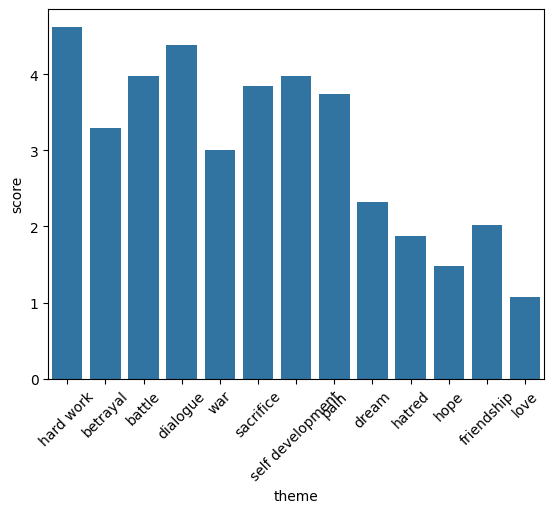

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data = theme_df ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()